In [24]:

import numpy as np
import os
import json
from collections import defaultdict
import re
import os 
import math
import seaborn as sns


In [8]:


def process_race_file(race_file):
    """Extract driver data from a single race JSON file and update the career results dictionary."""
    with open(race_file, 'r', encoding='utf-8') as file:
        race_data = json.load(file)

    race_name = race_data.get("race_name", "Unknown Race")
    race_date = race_data.get("date", "Unknown Date")
    race_results = race_data.get("results", {}).get("race", [])
    quali_results = race_data.get("results", {}).get("qualifying", [])
    fp1_results = race_data.get("results", {}).get("free_practice_1", [])
    fp2_results = race_data.get("results", {}).get("free_practice_2", [])
    fp3_results = race_data.get("results", {}).get("free_practice_3", [])
    fastest_laps = race_data.get("results", {}).get("fastest_laps", [])
    dotd = race_data.get("results", {}).get("driver_of_the_day", [])
    driver_standings = race_data.get("results", {}).get("driver", [])
    constructor_standings_and_past_race_winners = race_data.get("results", {}).get("constructor", [])


    drivers = []

    for entry in race_results:
        driver_name = entry["Driver"]
        driver_name_proc = driver_name.replace("#", "")
        driver_name_proc = re.sub(r'\d+', '', driver_name_proc)
        drivers.append(driver_name_proc)

        #create a json file for each driver
        if not os.path.exists(f"C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_driver_careers/{driver_name_proc}.json"):
            #create a json file for each driver
            with open(f"C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_driver_careers/{driver_name_proc}.json", 'w', encoding='utf-8') as file:
                json.dump({"driver_name": driver_name_proc}, file, indent=4)

        
        driver_team = entry["Constructor"]
        race_position = entry.get("Pos.", "Unknown")
        quali_entry = [q for q in quali_results if q["Driver"] == driver_name]
        quali_position = quali_entry[0].get("Pos.", "20") if quali_entry else "20"
        fp1_entry = [fp for fp in fp1_results if fp["Driver"] == driver_name]
        fp1_position = fp1_entry[0].get("Pos.", "Unknown") if fp1_entry else "Unknown"
        fp2_entry = [fp for fp in fp2_results if fp["Driver"] == driver_name]
        fp2_position = fp2_entry[0].get("Pos.", "Unknown") if fp2_entry else "Unknown"
        fp3_entry = [fp for fp in fp3_results if fp["Driver"] == driver_name]
        fp3_position = fp3_entry[0].get("Pos.", "Unknown") if fp3_entry else "Unknown"
        fastest_lap_entry = [fl for fl in fastest_laps if fl["Driver"] == driver_name]
        fastest_lap_position = fastest_lap_entry[0].get("Pos.", "Unknown") if fastest_lap_entry else "Unknown"
        dotd_entry = [d for d in dotd if 'Driver' in d and d["Driver"] == driver_name]
        dotd_position = dotd_entry[0].get("Pos.", "Unknown") if dotd_entry else "Unknown"
        driver_standings_entry = [ds for ds in driver_standings if ds["Driver"] == driver_name_proc]
        driver_standings_position = driver_standings_entry[0].get("Pos.", "Unknown") if driver_standings_entry else "Unknown"
        constructor_standings = [cs for cs in constructor_standings_and_past_race_winners if 'Constructor' in cs]
        constructor_standings_entry = [cs for cs in constructor_standings if cs["Constructor"] == driver_team]
        constructor_standings_position = constructor_standings_entry[0].get("Pos.", "Unknown") if constructor_standings_entry else "Unknown"

        if race_position in ['DNF', 'NC', 'DQ', 'DSQ', 'DNS', 'EX', 'DNQ', 'DNP', 'DNPQ']:
            race_position = 20
        if quali_position in ['DNQ','NC', 'DQ', 'DSQ', 'DNS', 'EX', 'DNP', 'DNPQ']:
            quali_position = 20



        rise_fall_factor = (int(quali_position) - int(race_position))

        with open(f"C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_driver_careers/{driver_name_proc}.json", 'r', encoding='utf-8') as file:
            driver_career_data = json.load(file)
        
        


        teammate_race_entry = [t for t in race_results if driver_team == t['Constructor'] and t["Driver"] != driver_name]
        teammate_name = teammate_race_entry[0]["Driver"] if teammate_race_entry else "Unknown"
        teammate_comp_factor_race = int(teammate_race_entry[0]["Pos."]) - int(race_position) if teammate_race_entry and teammate_race_entry[0]["Pos."] not in ['DNF', 'NC', 'DQ', 'DSQ','DNS','EX', 'DNQ', 'DNP', 'DNPQ'] else (20-int(race_position))
        teammate_quali_entry = [t for t in quali_results if driver_team == t['Constructor'] and t["Driver"] != driver_name]
        teammate_comp_factor_quali = int(teammate_quali_entry[0]["Pos."]) - int(quali_position) if teammate_quali_entry and teammate_quali_entry[0]["Pos."] not in ['DNQ','NC', 'DQ', 'DSQ', 'DNS', 'EX', 'DNP', 'DNPQ'] else (20-int(quali_position))


        position_to_points = {1:25, 2:18, 3:15, 4:12, 5:10, 6:8, 7:6,
                               8:4, 9:2, 10:1, 11:0, 12:0, 13:0, 14:0,
                                 15:0, 16:0, 17:0, 18:0, 19:0, 20:0,
                                 21:0, 22:0, 23:0, 24:0, 25:0, 26:0}

        points = position_to_points[int(race_position)] + (1 if fastest_lap_position == "1" else 0)
        


        weekend_score = 0
        if race_position != "Unknown":
            weekend_score += 20 * (21 - int(race_position))
        if quali_position != "Unknown":
            weekend_score += 10 * (21 - int(quali_position))
        if fp1_position != "Unknown":
            weekend_score += 1 * (21 - int(fp1_position))
        if fp2_position != "Unknown":
            weekend_score += 2 * (21 - int(fp2_position))
        if fp3_position != "Unknown":
            weekend_score += 3 * (21 - int(fp3_position))
        if fastest_lap_position != "Unknown":
            weekend_score += 4 * (21 - int(fastest_lap_position))
        if dotd_position != "Unknown":
            weekend_score += 5 * (6 - int(dotd_position))
        if rise_fall_factor != "Unknown":
            weekend_score += 8 * (rise_fall_factor)
        if teammate_comp_factor_race != "Unknown":
            weekend_score += 12 * int(teammate_comp_factor_race)
        if teammate_comp_factor_quali != "Unknown":
            weekend_score += 8 * int(teammate_comp_factor_quali)



        driver_career_data[race_name] = {
            "race_position": race_position,
            "points": points,
            "quali_position": quali_position,
            "fp1_position": fp1_position,
            "fp2_position": fp2_position,
            "fp3_position": fp3_position,
            "fastest_lap_position": fastest_lap_position,
            "dotd_position": dotd_position,
            "driver_standings_position": driver_standings_position,
            "constructor_standings_position": constructor_standings_position,
            "rise_fall_factor": rise_fall_factor,
            "teammate": teammate_name,
            "teammate_comp_race": teammate_comp_factor_race,
            "teammate_comp_quali": teammate_comp_factor_quali,
            "weekend_score": weekend_score
        }

        with open(f"C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_driver_careers/{driver_name_proc}.json", 'w', encoding='utf-8') as file:
            json.dump(driver_career_data, file, indent=4)




root = 'C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_all_seasons_results/2021'

years = list(range(1960, 2025))	

for year in years:
    root = f'C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_all_seasons_results/{year}'
    for file in os.listdir(root):
        if file.endswith(".json"):
            process_race_file(os.path.join(root, file))



In [16]:
base = 'C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/f1_driver_careers'


for file in os.listdir(base):
    with open(os.path.join(base,file), 'r', encoding='utf-8') as file:
        driver_career_data = json.load(file)

    driver_name = driver_career_data['driver_name']
    career_stats = defaultdict(int)

    total_races = 0
    total_weekend_score = 0
    avg_weekend_score = 0

    race_positions = []
    avg_race_position = 0

    points = []
    points_per_weekend = 0

    quali_positions = []
    avg_quali_position = 0

    fp1_positions = []
    avg_fp1_position = 0

    fp2_positions = []
    avg_fp2_position = 0

    fp3_positions = []
    avg_fp3_position = 0

    fastest_lap_positions = []
    avg_fastest_lap_position = 0

    rf_factors = []
    avg_rise_fall_factor = 0

    teammate_comp_race_factors = []
    avg_teammate_comp_race = 0

    teammate_comp_quali_factors = []
    avg_teammate_comp_quali = 0

    driver_standings_positions = []
    avg_driver_standings_position = 0

    constructor_standings_positions = []
    avg_constructor_standings_position = 0

    wins = 0
    win_percentage = 0


    for entry in driver_career_data:
        if 'Prix' in entry:
            total_races += 1
            # total_weekend_score += driver_career_data[entry]['weekend_score']
            race_positions.append(int(driver_career_data[entry]['race_position']))
            if race_positions[-1] == 1:
                wins += 1
            points.append(int(driver_career_data[entry]['points']))
            quali_positions.append(int(driver_career_data[entry]['quali_position']) if driver_career_data[entry]['quali_position'] not in ['Unknown'] else 10)
            fp1_positions.append(int(driver_career_data[entry]['fp1_position']) if driver_career_data[entry]['fp1_position'] not in ['Unknown'] else 10)
            fp2_positions.append(int(driver_career_data[entry]['fp2_position']) if driver_career_data[entry]['fp2_position'] not in ['Unknown'] else 10)
            fp3_positions.append(int(driver_career_data[entry]['fp3_position']) if driver_career_data[entry]['fp3_position'] not in ['Unknown'] else 10)
            fastest_lap_positions.append(int(driver_career_data[entry]['fastest_lap_position']) if driver_career_data[entry]['fastest_lap_position'] not in ['Unknown'] else 10)
            rf_factors.append(int(driver_career_data[entry]['rise_fall_factor']))
            teammate_comp_race_factors.append(int(driver_career_data[entry]['teammate_comp_race']))
            teammate_comp_quali_factors.append(int(driver_career_data[entry]['teammate_comp_quali']))
            driver_standings_positions.append(int(driver_career_data[entry]['driver_standings_position']) if driver_career_data[entry]['driver_standings_position'] not in ['EX','Unknown','DSQ'] else 10)
            constructor_standings_positions.append(int(driver_career_data[entry]['constructor_standings_position']) if driver_career_data[entry]['constructor_standings_position'] not in ['EX','Unknown'] else 5)
            updated_weekend_score = driver_career_data[entry]['weekend_score'] + (10 * points[-1])
            total_weekend_score += updated_weekend_score


    avg_weekend_score = total_weekend_score / total_races
    avg_race_position = np.mean(race_positions)
    points_per_weekend = np.mean(points)
    avg_quali_position = np.mean(quali_positions)
    avg_fp1_position = np.mean(fp1_positions)
    avg_fp2_position = np.mean(fp2_positions)
    avg_fp3_position = np.mean(fp3_positions)
    avg_fastest_lap_position = np.mean(fastest_lap_positions)
    avg_rise_fall_factor = np.mean(rf_factors)
    avg_teammate_comp_race = np.mean(teammate_comp_race_factors)
    avg_teammate_comp_quali = np.mean(teammate_comp_quali_factors)
    avg_driver_standings_position = np.mean(driver_standings_positions)
    avg_constructor_standings_position = np.mean(constructor_standings_positions)
    win_percentage = (wins / total_races) * 100

    normalisation_factor = math.log(total_races)


    career_score = (avg_weekend_score * normalisation_factor) 
    

    career_stats = {
        "total races": total_races,
        "wins": wins,
        "win percentage": win_percentage,
        "average weekend score": avg_weekend_score,
        "average race position": avg_race_position,
        "points per weekend": points_per_weekend,
        "average quali position": avg_quali_position,
        "average fp1 position": avg_fp1_position,
        "average fp2 position": avg_fp2_position,
        "average fp3 position": avg_fp3_position,
        "average fastest lap position": avg_fastest_lap_position,
        "average rise/fall factor": avg_rise_fall_factor,
        "average teammate comp race": avg_teammate_comp_race,
        "average teammate comp quali": avg_teammate_comp_quali,
        "average driver standings position": avg_driver_standings_position,
        "average constructor standings position": avg_constructor_standings_position,
        "normalisation factor": normalisation_factor,
        "career score": career_score
    }


    with open(f"C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats/{driver_name}_career_stats.json", 'w', encoding='utf-8') as file:
        json.dump(career_stats, file, indent=4)




#### Best Driver on Any Given Weekend 

C:\Users\athen\AppData\Local\Temp\ipykernel_12504\1193244315.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


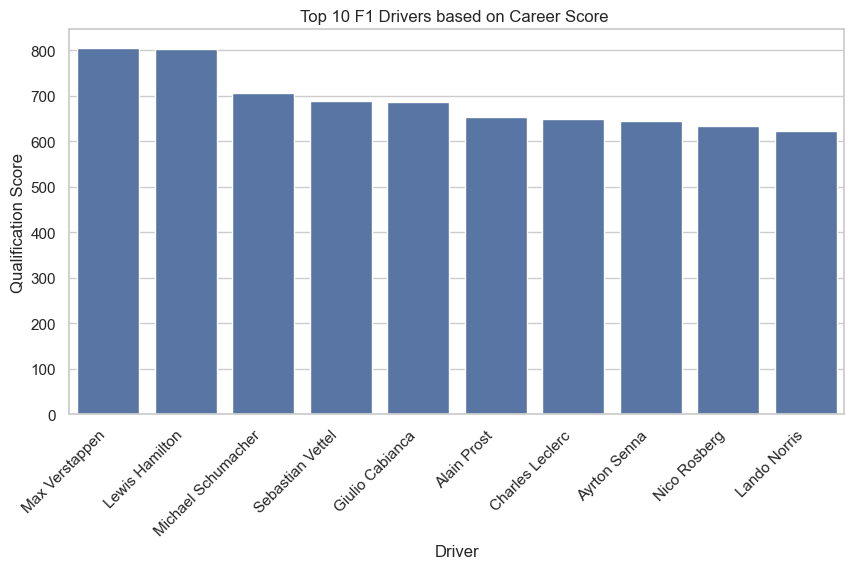

In [ ]:

driver_rankings = []

for file in os.listdir('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats'):
    with open(os.path.join('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats', file), 'r', encoding='utf-8') as f:
        driver_career_data = json.load(f)
        avg_weekend_score = driver_career_data.get("average weekend score", float('-inf'))
        
        if total_races >= 40:
            driver_rankings.append({
                "driver": file.replace('_career_stats.json', ''),
                "average_weekend_score": avg_weekend_score,
            })

driver_rankings.sort(key=lambda x: x["average_weekend_score"], reverse=True)
top_10_ws = driver_rankings[:10]

drivers = [d['driver'] for d in top_10_ws]
ws_scores = [d['average_weekend_score'] for d in top_10_ws]

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=drivers, y=ws_scores)
ax.set_title('Top 10 F1 Drivers based on Career Score ')
ax.set_ylabel('Qualification Score')
ax.set_xlabel('Driver')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.set(rc={'figure.figsize':(10,5)})

ax.figure.savefig('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/results/Top10DriversOnAnyGivenWeekend.png')




#### Best Driver by Career Score Metric 

C:\Users\athen\AppData\Local\Temp\ipykernel_12504\4028022503.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


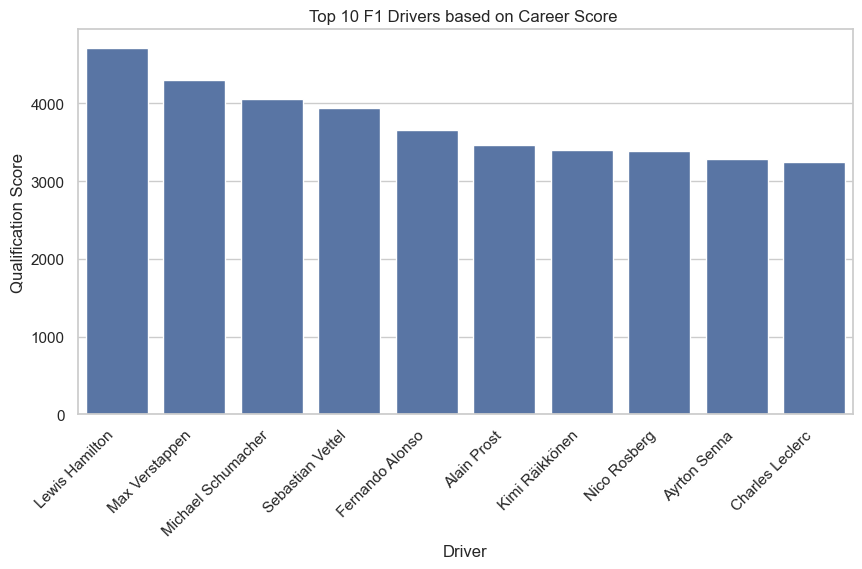

In [34]:

driver_rankings = []

for file in os.listdir('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats'):
    with open(os.path.join('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats', file), 'r', encoding='utf-8') as f:
        driver_career_data = json.load(f)
        total_races = driver_career_data.get("total races", 0)
        avg_weekend_score = driver_career_data.get("average weekend score", float('-inf'))
        career_score = driver_career_data.get("career score", float('-inf'))
        
        if total_races >= 30:
            driver_rankings.append({
                "driver": file.replace('_career_stats.json', ''),
                "average_weekend_score": avg_weekend_score,
                "career_score": career_score
            })

driver_rankings.sort(key=lambda x: x["career_score"], reverse=True)

with open('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_rankings.json', 'w', encoding='utf-8') as f:
    json.dump(driver_rankings, f, indent=4)


top_10_ws = driver_rankings[:10]

drivers = [d['driver'] for d in top_10_ws]
c_scores = [d['career_score'] for d in top_10_ws]

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=drivers, y=c_scores)
ax.set_title('Top 10 F1 Drivers based on Career Score ')
ax.set_ylabel('Qualification Score')
ax.set_xlabel('Driver')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.set(rc={'figure.figsize':(10,5)})

ax.figure.savefig('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/results/Top10DriversCareerScore.png')



#### Best Qualifier of All Time

C:\Users\athen\AppData\Local\Temp\ipykernel_12504\2449692577.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


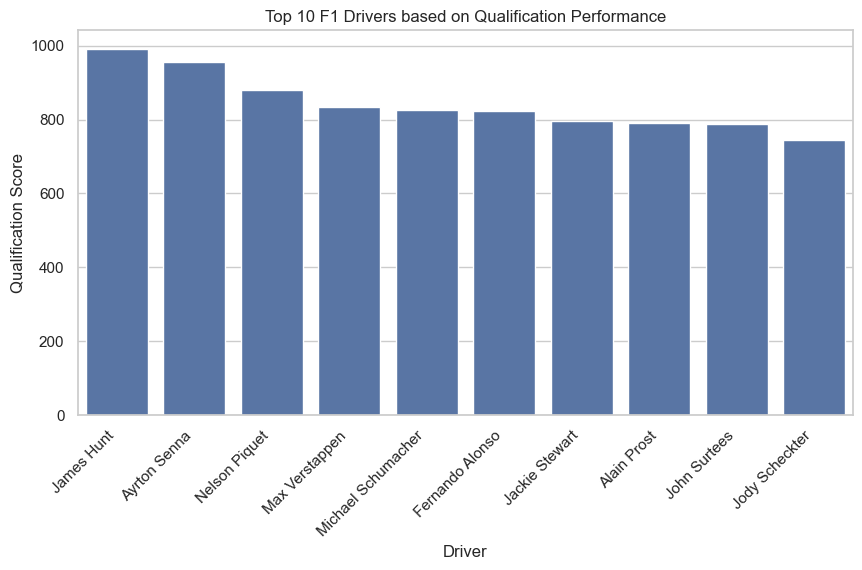

In [33]:
# Create a ranking of drivers based on their qualification performances
driver_rankings = []

for file in os.listdir('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats'):
    with open(os.path.join('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats', file), 'r', encoding='utf-8') as f:
        driver_career_data = json.load(f)
        total_races = driver_career_data.get("total races", 0)
        avg_quali_position = driver_career_data.get("average quali position", float('-inf'))
        teammate_comp_quali_factors = driver_career_data.get("average teammate comp quali", float('-inf'))
        avg_constructor_standings_position = driver_career_data.get("average constructor standings position", float('-inf'))
        normalisation_factor = driver_career_data.get("normalisation factor", float('-inf'))

        grid_size = 27 if avg_quali_position > 20 else 21
        quali_score = (2 * (grid_size - avg_quali_position)  + (5*teammate_comp_quali_factors) + (2 * (avg_constructor_standings_position))) * (3 * normalisation_factor)


        driver_rankings.append({
            "driver": file.replace('_career_stats.json', ''),
            "avg quali position": avg_quali_position,
            "avg constructor pos": avg_constructor_standings_position,
            "teammate quali comp": teammate_comp_quali_factors,
            "normalisation factor": normalisation_factor,
            "quali score": quali_score
        })

# Sort the rankings by average weekend score in descending order
driver_rankings.sort(key=lambda x: x["quali score"], reverse=True)

# Save the rankings to a JSON file
with open('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_quali_rankings.json', 'w', encoding='utf-8') as f:
    json.dump(driver_rankings, f, indent=4)



top_10_quali = driver_rankings[:10]

#visualise the top 10 drivers based on quali performance

drivers = [d['driver'] for d in top_10_quali]
quali_scores = [d['quali score'] for d in top_10_quali]

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=drivers, y=quali_scores)
ax.set_title('Top 10 F1 Drivers based on Qualification Performance')
ax.set_ylabel('Qualification Score')
ax.set_xlabel('Driver')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.set(rc={'figure.figsize':(10,5)})

ax.figure.savefig('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/results/Top10QualifyingDrivers.png')


#### Best Racers of All Time

C:\Users\athen\AppData\Local\Temp\ipykernel_12504\1151003722.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


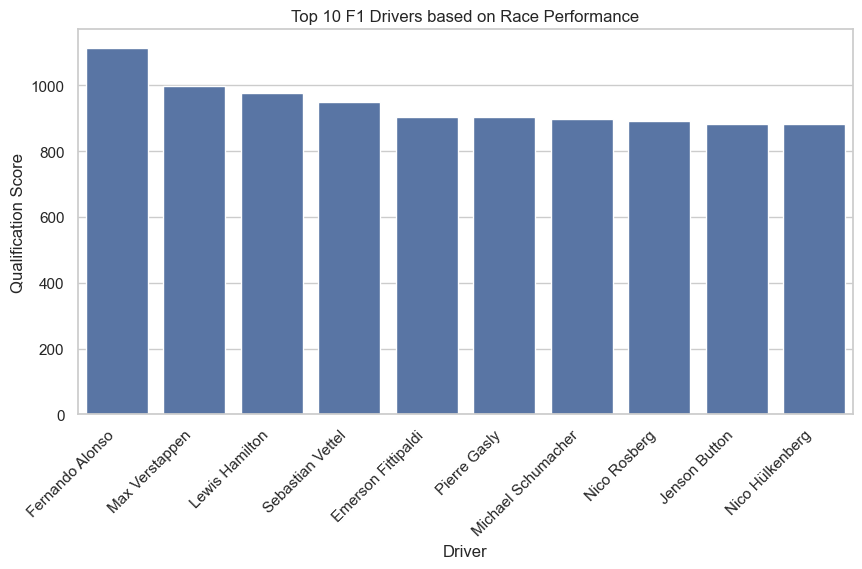

In [35]:
# Create a ranking of drivers based on their qualification performances
driver_rankings = []

for file in os.listdir('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats'):
    with open(os.path.join('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_career_stats', file), 'r', encoding='utf-8') as f:
        driver_career_data = json.load(f)
        total_races = driver_career_data.get("total races", 0)
        avg_race_position = driver_career_data.get("average race position", float('-inf'))
        avg_rise_fall_factor = driver_career_data.get("average rise/fall factor", float('-inf'))
        teammate_comp_race_factors = driver_career_data.get("average teammate comp quali", float('-inf'))
        avg_constructor_standings_position = driver_career_data.get("average constructor standings position", float('-inf'))
        normalisation_factor = driver_career_data.get("normalisation factor", float('-inf'))

        grid_size = 21 if avg_race_position < 20 else 27
        race_score = (3 * (grid_size - avg_race_position) + (2 * avg_rise_fall_factor)  + (2 * avg_constructor_standings_position) + (3 * teammate_comp_race_factors) + (2 * (avg_constructor_standings_position))) * (3 * normalisation_factor)


        driver_rankings.append({
            "driver": file.replace('_career_stats.json', ''),
            "avg race position": avg_quali_position,
            "teammate race comp": teammate_comp_quali_factors,
            "normalisation factor": normalisation_factor,
            "avg rise/fall factor": avg_rise_fall_factor,
            "race score": race_score
        })

# Sort the rankings by average weekend score in descending order
driver_rankings.sort(key=lambda x: x["race score"], reverse=True)

# Save the rankings to a JSON file
with open('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/data/driver_racing_rankings.json', 'w', encoding='utf-8') as f:
    json.dump(driver_rankings, f, indent=4)



top_10_race = driver_rankings[:10]

#visualise the top 10 drivers based on quali performance

drivers = [d['driver'] for d in top_10_race]
race_scores = [d['race score'] for d in top_10_race]

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=drivers, y=race_scores)
ax.set_title('Top 10 F1 Drivers based on Race Performance')
ax.set_ylabel('Qualification Score')
ax.set_xlabel('Driver')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.set(rc={'figure.figsize':(10,5)})


ax.figure.savefig('C:/Users/athen/Desktop/Github/BestF1DriverEverWithData/results/Top10DriversRaceOnly.png')

